In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from sklearn.model_selection import train_test_split
import plotly.graph_objects as go
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import os
import xgboost as xgb
from xgboost import plot_importance
import matplotlib.pyplot as plt

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Prepara o dataset ###

In [2]:
RANDOM_SEED=21

model = "xgboost"
src_type = "regular"

dir_results = f"../../data/results/{src_type}"
dir_figures = f"{dir_results}/figures/{model}"

if not os.path.exists(dir_figures):
    os.makedirs(dir_figures)

path_datasets = "../../data/datasets"
dataset = "Itaipu_POC_VAZAO_V2.csv"

## Número de Semanas Operativas Retroativas a serem utilizadas no Treinamento dos Algoritmos
n = 2

## Número da Semana Operativa Futura da Vazão a ser prevista pelos Modelos. min(f)=1
f = 2

In [3]:
df = pd.read_csv(f'{path_datasets}/{dataset}', index_col='time')
df

,bacia_prec_sum,vazao_itaipu
time,,
2000-06-30,2.539248e+05,217047.0
2000-07-31,2.773882e+05,229182.0
2000-08-31,4.983770e+05,229230.0
2000-09-30,8.890335e+05,407754.0
2000-10-31,4.884295e+05,267013.0
...,...,...
2021-08-31,9.598275e+04,123459.0
2021-09-30,1.757182e+05,114366.0
2021-10-31,1.389096e+06,259414.0


In [4]:
def dataset_constructor(df, n, f):
    for i in range(1, n): 
        df[f'bacia_prec_sum (time - {i})'] = df['bacia_prec_sum'].shift(i)
        df[f'vazao_itaipu (time - {i})'] = df['vazao_itaipu'].shift(i)

    df['bacia_prec_sum (time)'] = df['bacia_prec_sum']
    df['vazao_itaipu (time)'] = df['vazao_itaipu']

    for i in range(1,f+1):
        df[f'bacia_prec_sum (time + {i})'] = df['bacia_prec_sum'].shift(-i)
        
    df[f'vazao_itaipu (time + {f})'] = df['vazao_itaipu'].shift(-f)

    df = df.drop(columns=['bacia_prec_sum','vazao_itaipu'])
    df = df.dropna()
    
    return df

In [5]:
df = dataset_constructor(df, n, f)
df

,bacia_prec_sum (time - 1),vazao_itaipu (time - 1),bacia_prec_sum (time),vazao_itaipu (time),bacia_prec_sum (time + 1),bacia_prec_sum (time + 2),vazao_itaipu (time + 2)
time,,,,,,,
2000-07-31,253924.7500,217047.0,2.773882e+05,229182.0,4.983770e+05,8.890335e+05,407754.0
2000-08-31,277388.2500,229182.0,4.983770e+05,229230.0,8.890335e+05,4.884295e+05,267013.0
2000-09-30,498377.0000,229230.0,8.890335e+05,407754.0,4.884295e+05,1.056647e+06,284845.0
2000-10-31,889033.5000,407754.0,4.884295e+05,267013.0,1.056647e+06,1.203936e+06,412779.0
2000-11-30,488429.5000,267013.0,1.056647e+06,284845.0,1.203936e+06,1.009976e+06,427273.0
...,...,...,...,...,...,...,...
2021-06-30,214790.3125,154792.0,2.050504e+05,160122.0,8.400806e+04,9.598275e+04,123459.0
2021-07-31,205050.3750,160122.0,8.400806e+04,138688.0,9.598275e+04,1.757182e+05,114366.0
2021-08-31,84008.0625,138688.0,9.598275e+04,123459.0,1.757182e+05,1.389096e+06,259414.0


In [6]:
y_original = df.iloc[:,-1:]
y_original

,vazao_itaipu (time + 2)
time,
2000-07-31,407754.0
2000-08-31,267013.0
2000-09-30,284845.0
2000-10-31,412779.0
2000-11-30,427273.0
...,...
2021-06-30,123459.0
2021-07-31,114366.0
2021-08-31,259414.0


In [7]:
def scaling_data(df):
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()

    # Columns to scale for X and y
    columns_to_scale_X = df.columns[:-1]
    columns_to_scale_y = df.columns[-1]

    # Fit scalers on the selected columns and transform
    scaled_data_X = scaler_X.fit_transform(df[columns_to_scale_X])
    scaled_data_y = scaler_y.fit_transform(df[[columns_to_scale_y]])

    # Create DataFrame with scaled data
    scaled_X = pd.DataFrame(scaled_data_X, columns=columns_to_scale_X)
    scaled_y = pd.DataFrame(scaled_data_y, columns=[columns_to_scale_y])

    # Concatenate scaled columns to the original DataFrame
    new_df = pd.concat([pd.DataFrame(df.index), scaled_X, scaled_y], axis=1)
    new_df.set_index('time', inplace=True)

    return new_df, scaler_y

In [8]:
df, scaler_y = scaling_data(df)
df

,bacia_prec_sum (time - 1),vazao_itaipu (time - 1),bacia_prec_sum (time),vazao_itaipu (time),bacia_prec_sum (time + 1),bacia_prec_sum (time + 2),vazao_itaipu (time + 2)
time,,,,,,,
2000-07-31,0.129469,0.140064,0.141679,0.156617,0.256676,0.459964,0.400200
2000-08-31,0.141679,0.156617,0.256676,0.156682,0.459964,0.251500,0.208221
2000-09-30,0.256676,0.156682,0.459964,0.400200,0.251500,0.547186,0.232545
2000-10-31,0.459964,0.400200,0.251500,0.208221,0.547186,0.623832,0.407055
2000-11-30,0.251500,0.208221,0.547186,0.232545,0.623832,0.522900,0.426826
...,...,...,...,...,...,...,...
2021-06-30,0.109104,0.055144,0.104036,0.062414,0.041049,0.047280,0.012403
2021-07-31,0.104036,0.062414,0.041049,0.033177,0.047280,0.088772,0.000000
2021-08-31,0.041049,0.033177,0.047280,0.012403,0.088772,0.720184,0.197855


## Fazendo uma divisão treino/teste nos dados de vazão e aplicando normalização das colunas

In [9]:
X_data = df.iloc[:,:-1].astype('float64')
y_data = df.iloc[:,-1:].astype('float64')

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=RANDOM_SEED)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((204, 6), (52, 6), (204, 1), (52, 1))

## Treinamento

In [10]:
xb = xgb.XGBRegressor(eval_metric='rmsle',
                       learning_rate=0.2,
                       n_estimators=500,
                       max_depth=3)

xb.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric='rmsle', gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=500, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

## Retomamos a escala original dos dados

In [11]:
## _ stands for normalized data

y_pred_ = xb.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_.reshape(-1,1))

y_test_ = y_test
y_test = scaler_y.inverse_transform(y_test)

In [12]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
corr = np.corrcoef(y_test.T, y_pred.T)[0, 1]

metrics_df = pd.DataFrame(
    columns=['MAE', 'MSE', 'RMSE', 'R2', 'Corr'],
    index=['Decision Tree']
)

metrics_df['MAE'] = mae
metrics_df['MSE'] = mse
metrics_df['RMSE'] = rmse
metrics_df['R2'] = r2
metrics_df['Corr'] = corr
metrics_df

,MAE,MSE,RMSE,R2,Corr
Decision Tree,40279.846707,2.748400e+09,52425.182539,0.782358,0.887349


In [13]:
X_test.index

Index(['2013-06-30', '2016-09-30', '2006-05-31', '2012-05-31', '2007-10-31',
       '2013-09-30', '2021-07-31', '2010-03-31', '2020-02-29', '2016-10-31',
       '2007-06-30', '2017-06-30', '2014-03-31', '2005-07-31', '2015-01-31',
       '2019-01-31', '2003-11-30', '2001-01-31', '2003-08-31', '2002-03-31',
       '2017-11-30', '2016-02-29', '2016-04-30', '2017-09-30', '2005-02-28',
       '2016-05-31', '2019-11-30', '2014-07-31', '2004-11-30', '2021-02-28',
       '2017-08-31', '2005-09-30', '2020-09-30', '2001-04-30', '2016-07-31',
       '2021-01-31', '2020-10-31', '2018-03-31', '2008-08-31', '2015-04-30',
       '2002-04-30', '2004-05-31', '2020-11-30', '2020-01-31', '2001-12-31',
       '2011-04-30', '2009-03-31', '2008-06-30', '2006-10-31', '2009-04-30',
       '2012-03-31', '2010-02-28'],
      dtype='object', name='time')

In [14]:
X_data.index

Index(['2000-07-31', '2000-08-31', '2000-09-30', '2000-10-31', '2000-11-30',
       '2000-12-31', '2001-01-31', '2001-02-28', '2001-03-31', '2001-04-30',
       ...
       '2021-01-31', '2021-02-28', '2021-03-31', '2021-04-30', '2021-05-31',
       '2021-06-30', '2021-07-31', '2021-08-31', '2021-09-30', '2021-10-31'],
      dtype='object', name='time', length=256)

In [15]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=X_data.index,
        y=y_original.values.ravel(), # vazão observada
        mode='lines',
        name='Vazão observada',
    )
)

fig.add_trace(
    go.Scatter(
        x=X_test.index,
        y=y_pred.ravel(), # vazão prevista
        mode='markers',
        name='Forecast',
    )
)

fig.update_layout(title=f'Predição - Itaipu')

fig.write_image(f"{dir_figures}/history_measured_vs_predicted_plot.png", width=1400, scale=1)

fig.show()

In [16]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=y_test.flatten(),
        y=y_pred.flatten(),
        mode='markers',
        marker=dict(color='blue', opacity=0.5, line=dict(color='black', width=1)),
        name='Measured vs Predicted'
    )
)


fig.add_trace(
    go.Scatter(
        x=[y_pred.min(), y_pred.max()],
        y=[y_pred.min(), y_pred.max()],
        mode='lines',
        line=dict(color='red', dash='dash'),
        name='Identity Line'
    )
)

fig.update_layout(
    title='Measured vs Predicted',
    xaxis=dict(title='y_true'),
    yaxis=dict(title='y_pred'),
    autosize=False,
    width=800,
    height=500,
    margin=dict(l=0, r=0, b=0, t=40),
    showlegend=True
)

fig.write_image(f"{dir_figures}/scattered_measured_vs_predicted_plot.png")

fig.show()


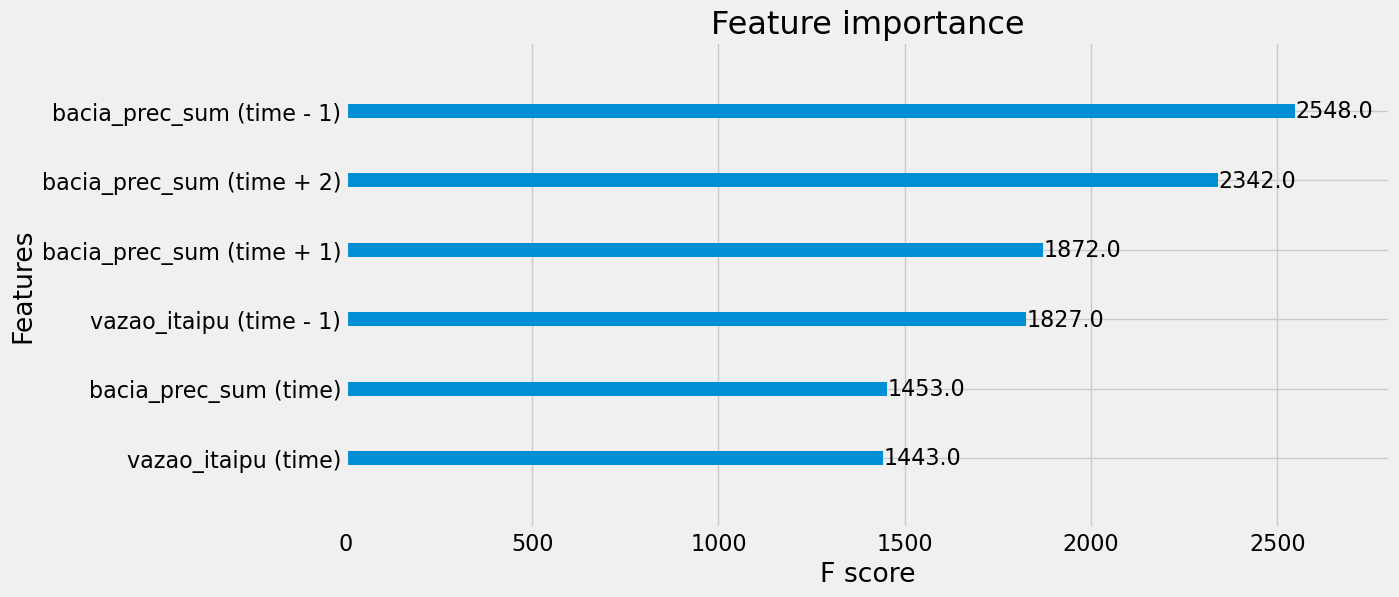

In [17]:
plt.style.use('fivethirtyeight')
plt.rcParams.update({'font.size': 16})

fig, ax = plt.subplots(figsize=(12,6))
plot_importance(xb, max_num_features=8, ax=ax)
plt.show()